In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# === Config ===
test_dir = "/tmp/e3/external_split/test"
model_path = "/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/Model/Mammo_EfficientNetB3_2class_512_model.h5"

2025-04-08 18:01:38.730267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 18:01:39.249708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# === Step 1: Load file paths & extract labels from filenames ===
test_paths = []
test_labels = []

for fname in os.listdir(test_dir):
    if fname.endswith(".png") and "_" in fname:
        label = fname.split("_")[0]  # prefix = label
        fpath = os.path.join(test_dir, fname)
        if os.path.exists(fpath):
            test_paths.append(fpath)
            test_labels.append(label)

print(f"✅ Total test images found: {len(test_paths)}")
print(f"✅ Label distribution: {Counter(test_labels)}")

✅ Total test images found: 985
✅ Label distribution: Counter({'White': 540, 'Asian': 445})


In [4]:
# === Step 2: Encode labels ===
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    encoded = [label_mapping[label] for label in labels]
    return encoded, label_mapping

encoded_test_labels, label_map = encode_labels(test_labels)
print("✅ Label mapping:", label_map)


✅ Label mapping: {'Asian': 0, 'White': 1}


In [5]:
# === Step 3: Create tf.data.Dataset ===
def create_test_dataset(filepaths, labels, batch_size=16):
    def load_image(filepath, label):
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [512, 512])
        return tf.cast(image, tf.float32) / 255.0, label

    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = create_test_dataset(test_paths, encoded_test_labels)

2025-04-08 18:02:01.200704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 18:02:01.203771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 18:02:01.228739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# === Step 4: Load model & evaluate ===
model = load_model(model_path)

# Evaluate accuracy/loss
loss, acc = model.evaluate(test_dataset)
print(f"\n✅ Test accuracy: {acc:.4f}, Loss: {loss:.4f}")

2025-04-08 18:02:16.714528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-08 18:02:16.736784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


62/62 [==============================] - 7s 90ms/step - loss: 0.5953 - accuracy: 0.7188

✅ Test accuracy: 0.7188, Loss: 0.5953


62/62 [==============================] - 5s 86ms/step

Classification Report:
              precision    recall  f1-score   support

       Asian       0.72      0.62      0.67       445
       White       0.72      0.80      0.76       540

    accuracy                           0.72       985
   macro avg       0.72      0.71      0.71       985
weighted avg       0.72      0.72      0.72       985



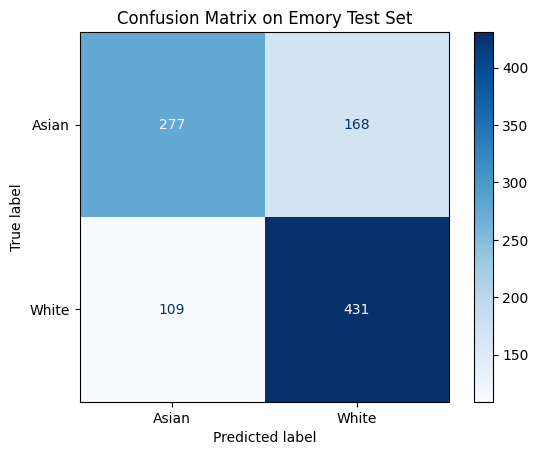

In [14]:
# === Step 5: Generate predictions and report ===
pred_probs = model.predict(test_dataset)
pred_classes = np.argmax(pred_probs, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(encoded_test_labels, pred_classes, target_names=label_map.keys()))

# Confusion Matrix
cm = confusion_matrix(encoded_test_labels, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap='Blues')
plt.style.use("default")
plt.title("Confusion Matrix on Emory Test Set")
plt.show()

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Convert true and predicted labels to numpy
y_true = np.array(encoded_test_labels)
y_pred = np.array(pred_classes)
y_score = pred_probs  # shape: (N, num_classes)

# === Sensitivity and Specificity ===
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

for i, class_name in enumerate(label_map.keys()):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    sensitivity = TP / (TP + FN) if (TP + FN) else 0
    specificity = TN / (TN + FP) if (TN + FP) else 0
    
    print(f"\nClass '{class_name}':")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")




Confusion Matrix:
 [[277 168]
 [109 431]]

Class 'Asian':
  Sensitivity (Recall): 0.6225
  Specificity: 0.7981

Class 'White':
  Sensitivity (Recall): 0.7981
  Specificity: 0.6225
